# A Genetic Algorithm for Producing Interesting Cellular Automata

Here I've implemented a genetic algorithm to produce a one-dimensional cellular-automata which produces "interesting" patterns. I define interesting as any pattern that maintains localized minorities over multiple generations. For instance, if most of the pixels in the 2d output are blue but there exist local 2-dimensional areas that are all yellow, I consider it to be interesting.

In [1]:
import numpy as np 
from matplotlib import pyplot as plt
import math
import random

In [2]:
# this function creates a random row of length n and with prop_b chance
# of each cell being black
def rand_row(n, prop_b):
    return ((np.random.random(n) < prop_b) * 1).tolist()

# this function creates a random rule of length 2^neighbors
def rand_rule(neighbors):
    n = pow(2, neighbors)
    return rand_row(n, .5)

# this function takes a row and a rule and produces
# the next row that would result from the application of that rule
def next_row(row, rule):
    neighbors = int(math.log2(len(rule)))
    rang = math.trunc(neighbors / 2)
    next_row = []
    for i in range(len(row)):
        definition = ""
        for n in range(neighbors):
            definition = definition + str(row[(i+n-rang) % (len(row))])
        # print(definition)
        next_row.append(rule[int(definition, 2)])

    return next_row

# this creates a matrix where each row is the succesive rule
# of the previous given the rule. It has N rows. If show = True
# it will display this matrix using a matplotlib heat map
def row_iterations(row, rule, N, show = False):
    matrix = [row]
    new_row = row
    for i in range(N-1):
        new_row = next_row(new_row, rule)
        matrix.append(new_row)

    matrix = np.array(matrix).astype(np.float)

    if show:
        plt.imshow(matrix)
        plt.show()
    
    return matrix

# this generates a matrix and can display a map of a matrix created
# by a random starting row and a rule
def gen_map(dimension, perc_zero, rule, show = False):
    return row_iterations(rand_row(dimension,perc_zero), rule, dimension, show)

# this function calculates the proportion of the matrix which is of value 1/black
def prop_one(map):
    dim = map.shape[0]
    return region_sum(map) / (dim * dim)

# this function returns a boolean value for whether or not a given matrix contains a
# a local group that is entirely composed of the given value (0 or 1)
def local_groups(map, value, size):
    dim = map.shape[0]
    for row in range(dim - size + 1):
        for col in range(dim - size + 1):
            locality = map[row:(row+size),col:(col+size)]
            ldim = locality.shape[0]
            tot = region_sum(locality)
            if value == 0 and tot == 0: return True
            if value == 1 and tot == ldim * ldim: return True
    return False

# this function calculates the total number of 1s in a given region of
# a matrix
def region_sum(region):
    dim = region.shape[0]
    tot = 0
    for row in range(dim):
        for col in range(dim):
            tot += region[row,col]
    return tot

# this returns whether or not there are localized minorities in a matrix
def localized_minorities(map, size):
    prop_1 = prop_one(map)
    if prop_1 > .5 and local_groups(map, 0, size): return True
    if prop_1 < .5 and local_groups(map, 1, size): return True
    return False
    
# this calculates the fitness of a rule by generating n_tests matrices
# with random starting rows and returning the proportion that have
# localized minorities.
def fitness(rule, n_tests, dims, perc_zero, locality_size):
    ctr = 0
    for i in range(n_tests):
        map = gen_map(dims, perc_zero, rule, show = False)
        if localized_minorities(map, locality_size): ctr += 1
    return ctr / n_tests

# this breeds two rules by splitting and concatenating them
# at a random index. It will then give it the mut_rate chance of 
# mutating n_mut times. It mutates by randomly switching the value
# of a random index
def breed(p1,p2,mut_rate,n_mut):
        
    sep = round(random.random() * len(p1))
    child = []

    for i in range(sep):
        child.append(p1[i])
    for i in range(sep, len(p1)):
        child.append(p2[i])
        
    for i in range(n_mut):
        if random.random() < mut_rate: 
            g = round(random.random() * (len(child)-1))
            if child[g] == 0: child[g] = 1
            else: child[g] = 0

    return child


In [3]:

# this populatin class is primarily a list of rules that has 
# convenient wrapper functions
class Population:

    # this function initializes the population with random rules
    def __init__(self, popsize, neighbors):
        self.rules = []
        for i in range(popsize):
            self.rules.append(rand_rule(neighbors))

    # this function returns the average fitness of the rules
    def avg_localized_mins(self, n_tests, dims, perc_zero, locality_size):
        ctr = 0
        for rule in self.rules:
            ctr += fitness(rule, n_tests, dims, perc_zero, locality_size) 
        return ctr / (len(self.rules))
    
    # this function returns the top elite_prop proportion of the population based
    # on their fitness
    def top_rules(self, elite_prop, n_tests, dims, perc_zero, locality_size):
        fits = []
        for i in range(len(self.rules)):
            f = fitness(self.rules[i], n_tests, dims, perc_zero, locality_size)
            fits.append([i,f])

        fits = np.array(sorted(fits,key=lambda x: x[1],reverse = True))
        stop_index = round(elite_prop * len(self.rules))
        
        top = []
        for i in range(0,stop_index):
            top.append(self.rules[int(fits[i,0])])

        return top

    # this function generates a new generation for the population by copying 
    # and breeding their top rules
    def next_gen(self, elite_prop, n_tests, dims, perc_zero, locality_size, mut_rate, n_mut):
        top = self.top_rules(elite_prop, n_tests, dims, perc_zero, locality_size)
        new_rules = top
        
        for i in range(len(top),len(self.rules)):
            p1 = random.choice(top)
            p2 = random.choice(top)
            new_rules.append(breed(p1,p2,mut_rate,n_mut))

        self.rules = new_rules

        return top

# this function creates a random population of rules and evolves them given
# the parameterization. It returns the top elite_prop of the final generation
# and produces a plot of fitness levels for the best rule in each generation
def generate_ca(popsize, generations, neighbors, n_tests, dims, perc_zero, 
                locality_size, elite_prop, mut_rate, n_mut, plot = False):
        pop = Population(popsize, neighbors)
        top_fit = []

        for i in range(generations):
            top = pop.next_gen(elite_prop, n_tests, dims, perc_zero, locality_size, mut_rate, n_mut)
            top_fit.append(fitness(top[0], n_tests, dims, perc_zero, locality_size))

        if plot:
            plt.plot(top_fit,color = "blue")
            plt.ylabel('Top Fitness')
            plt.xlabel('Generation')
            plt.show()
        
        return pop.top_rules(elite_prop, n_tests, dims, perc_zero, locality_size)
        


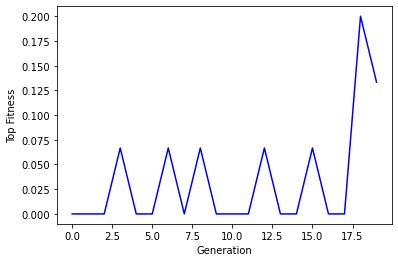

In [9]:
best = generate_ca(popsize = 50,
            generations = 20,
            neighbors = 5,
            n_tests = 15,
            dims = 50,
            perc_zero = .5,
            locality_size = 10,
            elite_prop = .2,
            mut_rate = .4,
            n_mut = 2,
            plot = True)


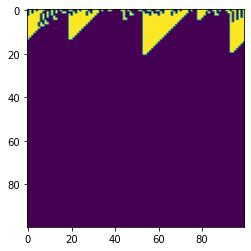

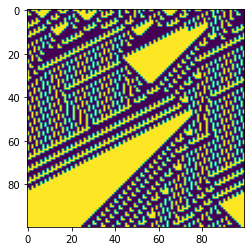

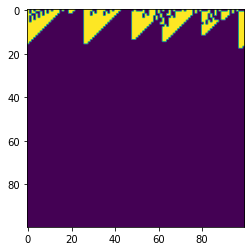

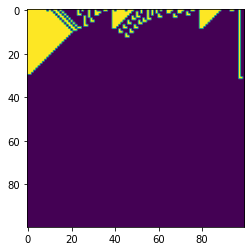

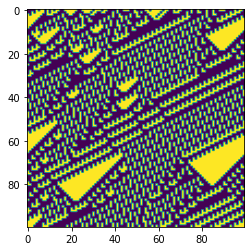

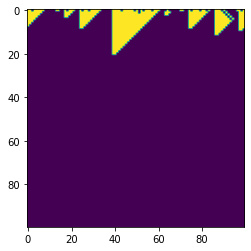

array([[1., 1., 0., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
gen_map(dimension = 100, 
        perc_zero = .5, 
        rule = best[0], 
        show = True)
gen_map(dimension = 100, 
        perc_zero = .5, 
        rule = best[1], 
        show = True)
gen_map(dimension = 100, 
        perc_zero = .5, 
        rule = best[2], 
        show = True)
gen_map(dimension = 100, 
        perc_zero = .5, 
        rule = best[3], 
        show = True)
gen_map(dimension = 100, 
        perc_zero = .5, 
        rule = best[4], 
        show = True)
gen_map(dimension = 100, 
        perc_zero = .5, 
        rule = best[5], 
        show = True)